In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, roc_auc_score, confusion_matrix)
from scipy.stats import entropy
import matplotlib.pyplot as plt
import cv2
import os
from joblib import Parallel, delayed
import time
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import multiprocessing
import pickle
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")
print(f"Available CPU cores: {multiprocessing.cpu_count()}")

✅ All libraries imported successfully!
💻 Available CPU cores: 8


In [ ]:
class GolfOptimizationAlgorithm:
    """Golf Optimization Algorithm with PARALLEL fitness evaluation"""
    
    def __init__(self, n_players=20, max_iterations=30, bounds=None, n_jobs=-1):
        self.n_players = n_players
        self.max_iterations = max_iterations
        self.bounds = bounds
        self.best_position = None
        self.best_fitness = -np.inf
        self.convergence_curve = []
        self.n_jobs = n_jobs if n_jobs > 0 else multiprocessing.cpu_count()
        
    def initialize_population(self):
        population = []
        for _ in range(self.n_players):
            player = {}
            for param, (low, high) in self.bounds.items():
                if isinstance(low, int):
                    player[param] = np.random.randint(low, high + 1)
                else:
                    player[param] = np.random.uniform(low, high)
            population.append(player)
        return population
    
    def optimize(self, fitness_function):
        population = self.initialize_population()
        
        print(f"Using {self.n_jobs} CPU cores for parallel processing")
        
        # Initial evaluation
        fitness_values = Parallel(n_jobs=self.n_jobs, verbose=0)(
            delayed(fitness_function)(player) for player in population
        )
        
        for iteration in range(self.max_iterations):
            iter_start = time.time()
            
            best_idx = np.argmax(fitness_values)
            if fitness_values[best_idx] > self.best_fitness:
                self.best_fitness = fitness_values[best_idx]
                self.best_position = population[best_idx].copy()
            
            new_population = []
            for i in range(self.n_players):
                if i != best_idx:
                    new_player = {}
                    for param in population[i].keys():
                        low, high = self.bounds[param]
                        r1, r2 = np.random.random(2)
                        new_value = (population[i][param] + 
                                    r1 * (self.best_position[param] - population[i][param]) +
                                    r2 * (population[best_idx][param] - population[i][param]))
                        
                        if isinstance(low, int):
                            new_value = int(np.clip(new_value, low, high))
                        else:
                            new_value = np.clip(new_value, low, high)
                        new_player[param] = new_value
                    new_population.append(new_player)
                else:
                    new_population.append(population[i].copy())
            
            population = new_population
            fitness_values = Parallel(n_jobs=self.n_jobs, verbose=0)(
                delayed(fitness_function)(player) for player in population
            )
            
            self.convergence_curve.append(self.best_fitness)
            print(f"Iter {iteration + 1}/{self.max_iterations} | Best F1: {self.best_fitness:.4f} | Time: {time.time()-iter_start:.2f}s")
        
        return self.best_position, self.best_fitness, self.convergence_curve


class ImagePreprocessor:
    """Handle image preprocessing with PARALLEL processing"""
    
    def __init__(self, target_size=(128, 128), n_jobs=-1):
        self.target_size = target_size
        self.n_jobs = n_jobs if n_jobs > 0 else multiprocessing.cpu_count()
        
    def _process_single_image(self, filepath):
        img = cv2.imread(filepath)
        if img is None:
            return None, None
        
        img_processed = self.preprocess_image(img)
        filename = os.path.basename(filepath)
        label = 0 if 'real' in filename.lower() else 1
        
        return img_processed, label
    
    def load_images(self, image_folder):
        image_paths = [
            os.path.join(image_folder, f) 
            for f in os.listdir(image_folder) 
            if f.endswith(('.jpg', '.jpeg', '.png'))
        ]
        
        print(f"📁 Loading {len(image_paths)} images...")
        start_time = time.time()
        
        results = Parallel(n_jobs=self.n_jobs, verbose=0)(
            delayed(self._process_single_image)(path) for path in image_paths
        )
        
        images, labels = zip(*[(img, lbl) for img, lbl in results if img is not None])
        
        print(f"✓ Loaded {len(images)} images in {time.time() - start_time:.2f}s")
        return np.array(images), np.array(labels)
    
    def preprocess_image(self, img):
        img = cv2.resize(img, self.target_size)
        img_normalized = img / 255.0
        return img_normalized.flatten()


class HyperparameterOptimizer:
    """Optimize ML hyperparameters"""
    
    def __init__(self, X_train, y_train, model_type='random_forest', n_jobs=-1):
        self.X_train = X_train
        self.y_train = y_train
        self.model_type = model_type
        self.n_jobs = n_jobs if n_jobs > 0 else multiprocessing.cpu_count()
        
    def get_param_bounds(self):
        if self.model_type == 'random_forest':
            return {
                'n_estimators': (50, 200),
                'max_depth': (5, 30),
                'min_samples_split': (2, 10),
                'min_samples_leaf': (1, 5)
            }
        
    def fitness_function(self, params):
        try:
            params_int = {k: int(v) for k, v in params.items()}
            model = RandomForestClassifier(**params_int, random_state=42, n_jobs=1)
            scores = cross_val_score(model, self.X_train, self.y_train, 
                                    cv=3, scoring='f1', n_jobs=1)
            return np.mean(scores)
        except Exception as e:
            return 0.0
    
    def optimize(self):
        bounds = self.get_param_bounds()
        goa = GolfOptimizationAlgorithm(
            n_players=15, max_iterations=20, bounds=bounds, n_jobs=self.n_jobs
        )
        return goa.optimize(self.fitness_function)


class ModelEvaluator:
    """Model evaluation"""
    
    @staticmethod
    def calculate_entropy(y_pred_proba):
        y_pred_proba = np.clip(y_pred_proba, 1e-10, 1)
        return entropy([np.mean(y_pred_proba), 1 - np.mean(y_pred_proba)])
    
    @staticmethod
    def evaluate(y_true, y_pred, y_pred_proba):
        return {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred, zero_division=0),
            'Recall': recall_score(y_true, y_pred, zero_division=0),
            'F1-Score': f1_score(y_true, y_pred, zero_division=0),
            'ROC-AUC': roc_auc_score(y_true, y_pred_proba),
            'Entropy': ModelEvaluator.calculate_entropy(y_pred_proba)
        }
    
    @staticmethod
    def plot_confusion_matrix(y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()
        
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, str(cm[i, j]), ha="center", va="center",
                        color="white" if cm[i, j] > cm.max() / 2 else "black")
        
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.xticks([0, 1], ['Real', 'Fake'])
        plt.yticks([0, 1], ['Real', 'Fake'])
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        return cm

print("All classes defined successfully!")

✅ All classes defined successfully!


In [ ]:
print("="*80)
print("[STEP 1] LOADING AND PREPROCESSING DATA")
print("="*80)

# Load images
preprocessor = ImagePreprocessor(target_size=(128, 128), n_jobs=-1)
X, y = preprocessor.load_images('data/')  # Change path to your data folder

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✓ Training samples: {len(X_train)}")
print(f"✓ Testing samples: {len(X_test)}")
print(f"✓ Feature dimensions: {X_train.shape[1]}")
print(f"✓ Class distribution: Real={np.sum(y==0)}, Fake={np.sum(y==1)}")

# SAVE DATA TO DISK (so you don't need to reload if something fails)
with open('preprocessed_data.pkl', 'wb') as f:
    pickle.dump({'X_train': X_train, 'X_test': X_test, 
                 'y_train': y_train, 'y_test': y_test}, f)

print("\nData saved to 'preprocessed_data.pkl'")
print("Step 1 complete!")

# (OPTIONAL) Load Previously Saved Data

# with open('preprocessed_data.pkl', 'rb') as f:
#     data = pickle.load(f)
#     X_train = data['X_train']
#     X_test = data['X_test']
#     y_train = data['y_train']
#     y_test = data['y_test']
# 
# print("Data loaded from disk!")
# print(f"Training samples: {len(X_train)}")

[STEP 1] LOADING AND PREPROCESSING DATA
📁 Loading 2041 images...


KeyboardInterrupt: 

In [ ]:
print("="*80)
print("[STEP 2] HYPERPARAMETER OPTIMIZATION")
print("="*80)

opt_start = time.time()

# Create optimizer
optimizer = HyperparameterOptimizer(X_train, y_train, n_jobs=-1)

# Run optimization (this will take time but show progress)
best_params, best_fitness, convergence = optimizer.optimize()

opt_elapsed = time.time() - opt_start

print(f"\n{'='*80}")
print("OPTIMIZATION COMPLETE!")
print(f"{'='*80}")
print(f"Total time: {opt_elapsed/60:.2f} minutes")
print(f"Best Parameters: {best_params}")
print(f"Best F1-Score: {best_fitness:.4f}")

# SAVE OPTIMIZATION RESULTS
with open('optimization_results.pkl', 'wb') as f:
    pickle.dump({
        'best_params': best_params,
        'best_fitness': best_fitness,
        'convergence': convergence
    }, f)

print("\nOptimization results saved to 'optimization_results.pkl'")
print("Step 2 complete!")


# (OPTIONAL) Load Previously Optimized Parameters

# with open('optimization_results.pkl', 'rb') as f:
#     opt_data = pickle.load(f)
#     best_params = opt_data['best_params']
#     best_fitness = opt_data['best_fitness']
#     convergence = opt_data['convergence']
# 
# print("✅ Optimization results loaded from disk!")
# print(f"Best Parameters: {best_params}")
# print(f"Best F1-Score: {best_fitness:.4f}")



[STEP 2] HYPERPARAMETER OPTIMIZATION
🚀 Using 8 CPU cores for parallel processing
Iter 1/20 | Best F1: 0.5253 | Time: 79.44s
Iter 2/20 | Best F1: 0.5382 | Time: 108.04s
Iter 3/20 | Best F1: 0.5382 | Time: 91.80s
Iter 4/20 | Best F1: 0.5421 | Time: 84.90s
Iter 5/20 | Best F1: 0.5421 | Time: 79.07s
Iter 6/20 | Best F1: 0.5421 | Time: 94.96s
Iter 7/20 | Best F1: 0.5421 | Time: 94.51s
Iter 8/20 | Best F1: 0.5421 | Time: 92.88s
Iter 9/20 | Best F1: 0.5421 | Time: 93.99s
Iter 10/20 | Best F1: 0.5421 | Time: 94.53s
Iter 11/20 | Best F1: 0.5421 | Time: 92.64s
Iter 12/20 | Best F1: 0.5421 | Time: 93.61s
Iter 13/20 | Best F1: 0.5421 | Time: 91.58s
Iter 14/20 | Best F1: 0.5421 | Time: 91.88s
Iter 15/20 | Best F1: 0.5421 | Time: 91.58s
Iter 16/20 | Best F1: 0.5421 | Time: 90.81s
Iter 17/20 | Best F1: 0.5421 | Time: 91.18s
Iter 18/20 | Best F1: 0.5421 | Time: 91.08s
Iter 19/20 | Best F1: 0.5421 | Time: 90.04s
Iter 20/20 | Best F1: 0.5421 | Time: 90.87s

OPTIMIZATION COMPLETE!
⏱ Total time: 33.53 min

In [ ]:
print("="*80)
print("[STEP 3] TRAINING FINAL MODEL")
print("="*80)

train_start = time.time()

# Convert params to integers
params_int = {k: int(v) for k, v in best_params.items()}

# Train model with all CPU cores
final_model = RandomForestClassifier(**params_int, random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

train_elapsed = time.time() - train_start
print(f"Model trained in {train_elapsed:.2f}s")

# SAVE TRAINED MODEL
with open('final_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("Model saved to 'final_model.pkl'")
print("Step 3 complete!")

[STEP 3] TRAINING FINAL MODEL
✓ Model trained in 2.12s
💾 Model saved to 'final_model.pkl'
✅ Step 3 complete!


In [18]:
print("="*80)
print("[STEP 4] MODEL EVALUATION")
print("="*80)

# Make predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate metrics
metrics = ModelEvaluator.evaluate(y_test, y_pred, y_pred_proba)

print(f"\n{'='*80}")
print("FINAL RESULTS")
print(f"{'='*80}")
for metric, value in metrics.items():
    print(f"{metric:15s}: {value:.4f}")

print("\n✅ Step 4 complete!")

[STEP 4] MODEL EVALUATION

FINAL RESULTS
Accuracy       : 0.6161
Precision      : 0.6000
Recall         : 0.5469
F1-Score       : 0.5722
ROC-AUC        : 0.6535
Entropy        : 0.6922

✅ Step 4 complete!


[STEP 5] GENERATING VISUALIZATIONS

📊 Confusion Matrix:


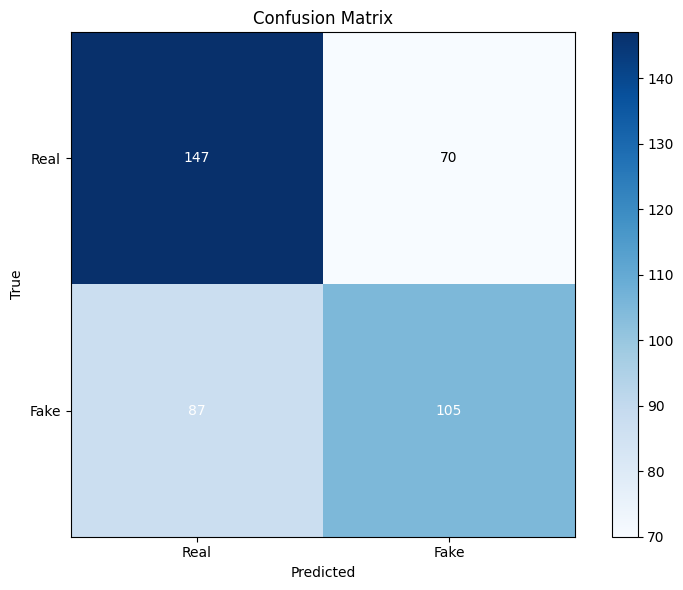

[[147  70]
 [ 87 105]]


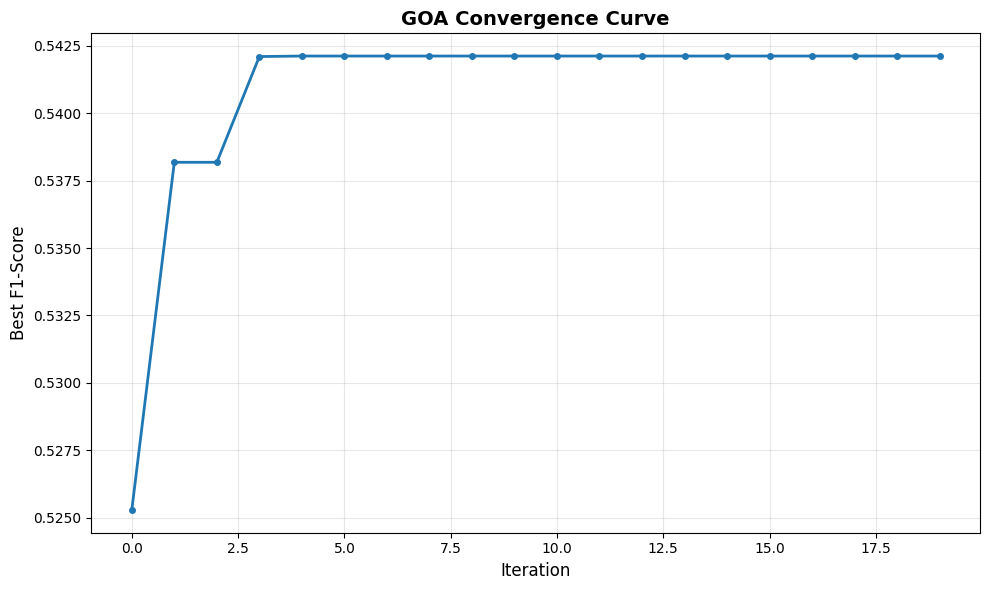


✅ All visualizations saved!
   - confusion_matrix.png
   - convergence_curve.png


In [ ]:
print("="*80)
print("[STEP 5] GENERATING VISUALIZATIONS")
print("="*80)

# Plot confusion matrix
print("\n📊 Confusion Matrix:")
cm = ModelEvaluator.plot_confusion_matrix(y_test, y_pred)
print(cm)

# Plot convergence curve
plt.figure(figsize=(10, 6))
plt.plot(convergence, marker='o', linewidth=2, markersize=4)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Best F1-Score', fontsize=12)
plt.title('GOA Convergence Curve', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('convergence_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAll visualizations saved!")
print("   - confusion_matrix.png")
print("   - convergence_curve.png")

In [ ]:
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)

# Create results DataFrame
results_df = pd.DataFrame({
    'Metric': list(metrics.keys()),
    'Value': list(metrics.values())
})

print("\nPerformance Metrics:")
print(results_df.to_string(index=False))

# Save results to CSV
results_df.to_csv('results.csv', index=False)
print("\nResults saved to 'results.csv'")

# Save complete report
report = {
    'best_params': best_params,
    'best_fitness': best_fitness,
    'test_metrics': metrics,
    'confusion_matrix': cm.tolist(),
    'convergence_curve': convergence,
    'training_samples': len(X_train),
    'testing_samples': len(X_test)
}

with open('complete_report.pkl', 'wb') as f:
    pickle.dump(report, f)

print("Complete report saved to 'complete_report.pkl'")
print("\n" + "="*80)
print("ALL STEPS COMPLETED SUCCESSFULLY!")
print("="*80)


FINAL SUMMARY

📊 Performance Metrics:
   Metric    Value
 Accuracy 0.616137
Precision 0.600000
   Recall 0.546875
 F1-Score 0.572207
  ROC-AUC 0.653490
  Entropy 0.692239

💾 Results saved to 'results.csv'
💾 Complete report saved to 'complete_report.pkl'

✅ ALL STEPS COMPLETED SUCCESSFULLY!
